# 1. Import library

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# !pip install optuna
# !pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import gc
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm.sklearn import LGBMRegressor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna
import plotly

gc.collect()
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
# pd.get_option('display.max_columns')

In [2]:
# 메모리 축소
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
# train = pd.read_csv('/content/drive/MyDrive/배그 순위예측/train_V2.csv')
# test = pd.read_csv('/content/drive/MyDrive/배그 순위예측/test_V2.csv')

# train = pd.read_csv('./배그 순위예측/train_V2.csv')
# test = pd.read_csv('./배그 순위예측/test_V2.csv')
import os
file_path = os.getcwd() + "/배그 순위예측/"
sample_submission = pd.read_csv(file_path + "sample_submission_V2.csv")
train = pd.read_csv(file_path + "train_V2.csv")
test = pd.read_csv(file_path + "test_V2.csv")

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [5]:
# 결측치 확인 및 제거
train.isna().any(axis=1).sum()
train = train.dropna()

In [6]:
train.shape

(4446965, 29)

# 2. EDA

In [7]:
temp = train.copy()

In [8]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

##### To-do
matchType은 object로, training 및 predict할 시 one-hot encoding 해주기

In [9]:
temp.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000
mean,0.23381,1.10691,NaN,0.65788,0.22682,1.37015,47.59936,505.00616,0.92478,0.54396,NaN,1579.50679,44.50468,43.00760,892.01030,0.16466,NaN,0.00350,NaN,0.02387,0.00792,NaN,3.66049,606.46027,NaN
std,0.58857,1.71579,NaN,1.14574,0.60216,2.67998,27.46293,627.50492,1.55844,0.71097,NaN,258.73881,23.82810,23.28949,736.64779,0.47217,NaN,0.07337,NaN,0.16739,0.09261,NaN,2.45654,739.70047,0.00000
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,133.00000,2.00000,1.00000,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,24.00000,0.00000,0.00000,0.00000,0.00000,1367.00000,28.00000,27.00000,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,155.12500,2.00000,0.00000,0.19995
50%,0.00000,0.00000,84.25000,0.00000,0.00000,0.00000,47.00000,0.00000,0.00000,0.00000,0.00000,1438.00000,30.00000,30.00000,1443.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,685.50000,3.00000,0.00000,0.45825
75%,0.00000,2.00000,186.00000,1.00000,0.00000,2.00000,71.00000,1172.00000,1.00000,1.00000,21.31250,1851.00000,49.00000,47.00000,1500.00000,0.00000,0.19104,0.00000,0.00000,0.00000,0.00000,1976.00000,5.00000,1495.00000,0.74072
max,22.00000,33.00000,6616.00000,53.00000,64.00000,80.00000,101.00000,2170.00000,72.00000,20.00000,1094.00000,2237.00000,100.00000,100.00000,5910.00000,39.00000,40704.00000,18.00000,3824.00000,12.00000,5.00000,25776.00000,236.00000,2013.00000,1.00000


In [12]:
temp.describe(include='O')

,Id,groupId,matchId,matchType
count,4446965,4446965,4446965,4446965
unique,4446965,2026744,47964,16
top,7f96b2f878858a,14d6b54cdec6bc,4b5db40aec4797,squad-fpp
freq,1,74,100,1756186


##### Insight
1. matchType으로는 squad-fpp가 가장 많음
2. groupId로는 "14d6b54cdec6bc"가 가장 많았음(solo game일 확률 있음) - 탐색 결과 normal-squad-fpp였음.<br>**squad가 그룹이 50개 이상 넘어갈 수 없으므로 데이터 탐색 필요**

In [16]:
temp.loc[temp["groupId"] == "14d6b54cdec6bc", "matchType"].value_counts()

normal-squad-fpp    74
Name: matchType, dtype: int64

## 2-1. Feature 관계 분석

### 2-1-1. 상관관계 분석

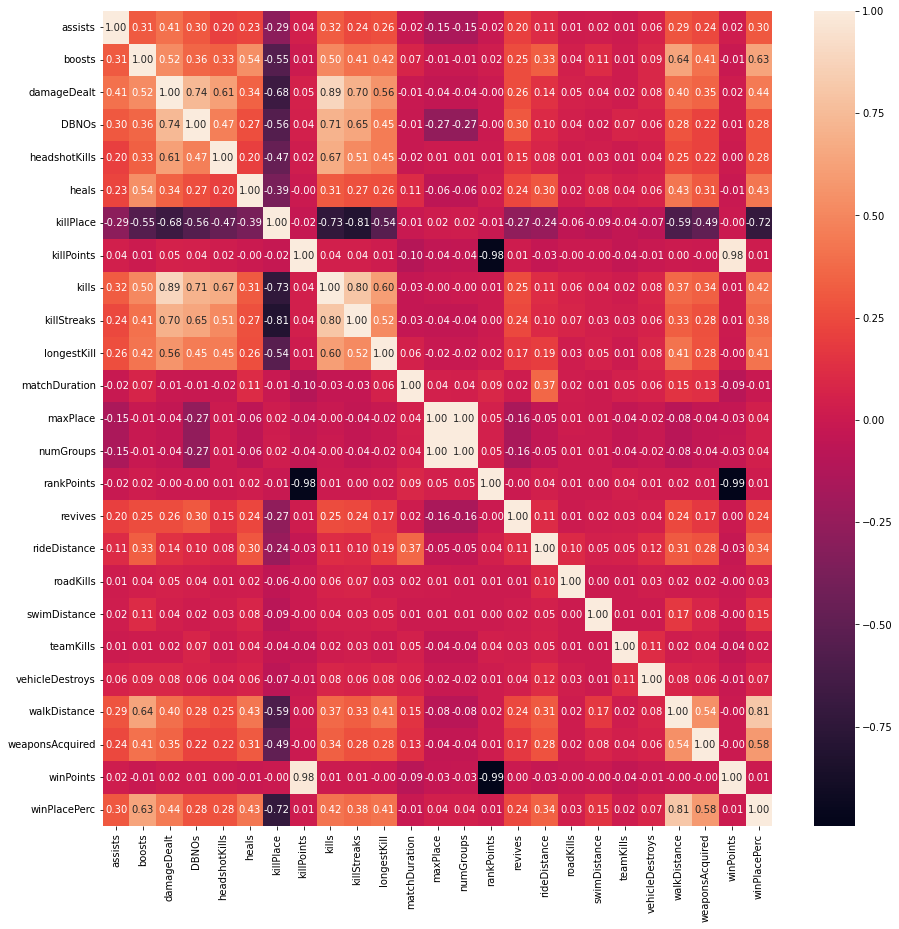

In [17]:
plt.figure(figsize=(15, 15))
sns.heatmap(temp.corr(), annot=True, fmt=".2f")
plt.show()

In [18]:
temp.corr()["winPlacePerc"].sort_values(ascending=False)[1:]

walkDistance       0.81089
boosts             0.63423
weaponsAcquired    0.58381
damageDealt        0.44051
heals              0.42786
kills              0.41992
longestKill        0.41015
killStreaks        0.37757
rideDistance       0.34291
assists            0.29944
DBNOs              0.27997
headshotKills      0.27772
revives            0.24088
swimDistance       0.14961
vehicleDestroys    0.07344
numGroups          0.03962
maxPlace           0.03738
roadKills          0.03454
teamKills          0.01594
rankPoints         0.01352
killPoints         0.01291
winPoints          0.00706
matchDuration     -0.00517
killPlace         -0.71907
Name: winPlacePerc, dtype: float64

#### Insight
1. 분석 결과 **walkDistance > boosts > weaponsAcquired > damageDealt > heals > kills > longestKill**이 label(target)인 winPlacePerc와 상관관계가 높음(이들 feature들을 분석)
2. 상관관계 분석, VIF 분석, RF의 feature_importance, LGBM의 feature_importance, PCA등 다양한 feature 분석 툴들을 통해 공통의 feature를 추출하는 것을 고려해봄

### 2-1-2. Variance Inflation Factor 분석(다중공선성 분석)

In [21]:
# 다중공선성 확인을 위한 전처리
temp_features = temp.drop(['Id', 'groupId', 'matchId', 'winPlacePerc'], axis=1)
encoder = LabelEncoder()
encoder.fit(temp_features['matchType'])
temp_features['matchType'] = encoder.transform(temp_features['matchType'])

In [22]:
# R^2 = 0.832
temp_features = sm.add_constant(temp_features)
model_1 = sm.OLS(temp['winPlacePerc'], temp_features).fit()
print(model_1.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.832        
Dependent Variable: winPlacePerc     AIC:                -5798234.2877
Date:               2022-06-19 00:47 BIC:                -5797888.2866
No. Observations:   4446965          Log-Likelihood:     2.8991e+06   
Df Model:           25               F-statistic:        8.797e+05    
Df Residuals:       4446939          Prob (F-statistic): 0.00         
R-squared:          0.832            Scale:              0.015895     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.7680   0.0013   603.1843 0.0000  0.7655  0.7705
assists              0.0143   0.0001   124.1010 0.0000  0.0141  0.0145
boosts               0.0143   0.0001   269.8680 0.0000  0.0142  0.0144
damageDealt          0.000

In [23]:
temp_features = temp_features.drop('const', axis=1)
pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(temp_features.values, idx) for idx in range(temp_features.shape[1])],
    "features": temp_features.columns
}).sort_values("VIF Factor", ascending=False)

,VIF Factor,features
13,1123.39718,maxPlace
14,1095.57367,numGroups
24,84.70251,winPoints
7,53.50931,killPoints
11,43.37556,matchDuration
15,42.63016,rankPoints
6,18.54644,killPlace
8,10.92460,kills
2,9.69276,damageDealt
9,7.40632,killStreaks


In [24]:
# R^2 0.832
temp_features = sm.add_constant(temp_features)
model_1 = sm.OLS(temp['winPlacePerc'], temp_features).fit()
print(model_1.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.832        
Dependent Variable: winPlacePerc     AIC:                -5798234.2877
Date:               2022-06-19 00:56 BIC:                -5797888.2866
No. Observations:   4446965          Log-Likelihood:     2.8991e+06   
Df Model:           25               F-statistic:        8.797e+05    
Df Residuals:       4446939          Prob (F-statistic): 0.00         
R-squared:          0.832            Scale:              0.015895     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.7680   0.0013   603.1843 0.0000  0.7655  0.7705
assists              0.0143   0.0001   124.1010 0.0000  0.0141  0.0145
boosts               0.0143   0.0001   269.8680 0.0000  0.0142  0.0144
damageDealt          0.000

In [25]:
temp_features = temp_features.drop(['const', 'maxPlace'], axis=1)
pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(temp_features.values, idx) for idx in range(temp_features.shape[1])],
    "features": temp_features.columns
}).sort_values("VIF Factor", ascending=False)

,VIF Factor,features
23,84.37958,winPoints
7,53.43616,killPoints
11,42.48679,matchDuration
14,42.47909,rankPoints
6,18.32922,killPlace
8,10.92409,kills
2,9.69132,damageDealt
9,7.37013,killStreaks
13,5.70900,numGroups
12,5.24775,matchType


In [27]:
# R^2 0.830
temp_features = sm.add_constant(temp_features)
model_1 = sm.OLS(temp['winPlacePerc'], temp_features).fit()
print(model_1.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.830        
Dependent Variable: winPlacePerc     AIC:                -5753353.5170
Date:               2022-06-19 01:03 BIC:                -5753020.8237
No. Observations:   4446965          Log-Likelihood:     2.8767e+06   
Df Model:           24               F-statistic:        9.053e+05    
Df Residuals:       4446940          Prob (F-statistic): 0.00         
R-squared:          0.830            Scale:              0.016056     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.7564   0.0013   591.6609 0.0000  0.7539  0.7589
assists              0.0145   0.0001   125.4513 0.0000  0.0143  0.0148
boosts               0.0143   0.0001   268.2464 0.0000  0.0142  0.0144
damageDealt          0.000

In [28]:
temp_features = temp_features.drop(['const', 'winPoints'], axis=1)
pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(temp_features.values, idx) for idx in range(temp_features.shape[1])],
    "features": temp_features.columns
}).sort_values("VIF Factor", ascending=False)

,VIF Factor,features
11,36.11573,matchDuration
14,27.06091,rankPoints
7,17.93863,killPoints
6,16.45490,killPlace
8,10.92400,kills
2,9.68714,damageDealt
9,7.08595,killStreaks
13,5.41846,numGroups
12,5.23052,matchType
22,4.98214,weaponsAcquired


In [31]:
# R^2 0.829
temp_features = sm.add_constant(temp_features)
model_1 = sm.OLS(temp['winPlacePerc'], temp_features).fit()
print(model_1.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.829        
Dependent Variable: winPlacePerc     AIC:                -5735615.6833
Date:               2022-06-19 01:08 BIC:                -5735296.2977
No. Observations:   4446965          Log-Likelihood:     2.8678e+06   
Df Model:           23               F-statistic:        9.401e+05    
Df Residuals:       4446941          Prob (F-statistic): 0.00         
R-squared:          0.829            Scale:              0.016120     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.8898   0.0008  1114.9777 0.0000  0.8882  0.8913
assists              0.0147   0.0001   126.9292 0.0000  0.0145  0.0150
boosts               0.0143   0.0001   268.1028 0.0000  0.0142  0.0144
damageDealt          0.000

In [32]:
temp_features = temp_features.drop(['const', 'matchDuration'], axis=1)
pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(temp_features.values, idx) for idx in range(temp_features.shape[1])],
    "features": temp_features.columns
}).sort_values("VIF Factor", ascending=False)

,VIF Factor,features
13,21.17131,rankPoints
7,14.40199,killPoints
6,13.99973,killPlace
8,10.90330,kills
2,9.68449,damageDealt
9,6.77591,killStreaks
12,5.28008,numGroups
11,5.21639,matchType
21,4.84216,weaponsAcquired
20,4.62638,walkDistance


In [33]:
# R^2 0.813
temp_features = sm.add_constant(temp_features)
model_1 = sm.OLS(temp['winPlacePerc'], temp_features).fit()
print(model_1.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.813        
Dependent Variable: winPlacePerc     AIC:                -5324646.0337
Date:               2022-06-19 01:13 BIC:                -5324339.9559
No. Observations:   4446965          Log-Likelihood:     2.6623e+06   
Df Model:           22               F-statistic:        8.783e+05    
Df Residuals:       4446942          Prob (F-statistic): 0.00         
R-squared:          0.813            Scale:              0.017681     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.6426   0.0007   872.1710 0.0000  0.6412  0.6441
assists              0.0187   0.0001   153.7448 0.0000  0.0184  0.0189
boosts               0.0166   0.0001   297.7613 0.0000  0.0165  0.0168
damageDealt          0.000

In [35]:
temp_features = temp_features.drop(['const', 'rankPoints'], axis=1)
pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(temp_features.values, idx) for idx in range(temp_features.shape[1])],
    "features": temp_features.columns
}).sort_values("VIF Factor", ascending=False)

,VIF Factor,features
8,10.87401,kills
2,9.60962,damageDealt
6,5.57287,killPlace
9,5.15523,killStreaks
11,4.78969,matchType
12,4.62414,numGroups
20,4.53063,weaponsAcquired
19,4.31677,walkDistance
3,3.71804,DBNOs
1,3.27369,boosts


In [36]:
# R^2 0.813
temp_features = sm.add_constant(temp_features)
model_1 = sm.OLS(temp['winPlacePerc'], temp_features).fit()
print(model_1.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.813        
Dependent Variable: winPlacePerc     AIC:                -5320930.6185
Date:               2022-06-19 01:19 BIC:                -5320637.8484
No. Observations:   4446965          Log-Likelihood:     2.6605e+06   
Df Model:           21               F-statistic:        9.191e+05    
Df Residuals:       4446943          Prob (F-statistic): 0.00         
R-squared:          0.813            Scale:              0.017696     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.6777   0.0005  1469.2596 0.0000  0.6768  0.6786
assists              0.0188   0.0001   154.9363 0.0000  0.0186  0.0191
boosts               0.0168   0.0001   300.1569 0.0000  0.0167  0.0169
damageDealt          0.000

In [38]:
temp_features = temp_features.drop(['const', 'kills'], axis=1)
pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(temp_features.values, idx) for idx in range(temp_features.shape[1])],
    "features": temp_features.columns
}).sort_values("VIF Factor", ascending=False)

,VIF Factor,features
2,6.32902,damageDealt
6,5.43677,killPlace
10,4.78950,matchType
11,4.60352,numGroups
19,4.52603,weaponsAcquired
8,4.34759,killStreaks
18,4.28207,walkDistance
3,3.70001,DBNOs
1,3.24900,boosts
9,2.02156,longestKill


In [39]:
# R^2 0.812
temp_features = sm.add_constant(temp_features)
model_1 = sm.OLS(temp['winPlacePerc'], temp_features).fit()
print(model_1.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.812        
Dependent Variable: winPlacePerc     AIC:                -5309211.6344
Date:               2022-06-19 01:25 BIC:                -5308932.1720
No. Observations:   4446965          Log-Likelihood:     2.6546e+06   
Df Model:           20               F-statistic:        9.620e+05    
Df Residuals:       4446944          Prob (F-statistic): 0.00         
R-squared:          0.812            Scale:              0.017743     
----------------------------------------------------------------------
                     Coef.  Std.Err.     t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                0.6804   0.0005  1475.5288 0.0000  0.6795  0.6813
assists              0.0197   0.0001   161.9833 0.0000  0.0194  0.0199
boosts               0.0163   0.0001   291.4667 0.0000  0.0161  0.0164
damageDealt         -0.000

상관관계 분석의 상위 7개의 walkDistance > boosts > weaponsAcquired > damageDealt > heals > kills > longestKill<br>
feature들과, VIF 분석을 통해 다중공선성을 최소화하고 독립성을 지닌 feature들이 kills를 제외하고 같게 나왔음.<br>
이를 토대로 feature 분석

## 2-2 feature별 분석

### 2-2-1. walkDistance 분석

In [44]:
# index list 변환 코드
idx = [i.strip() for i in temp['walkDistance'].describe().index.tolist()]
for i in idx:
    print(f"walkDistance {i}: {temp['walkDistance'].describe()[i]}")

walkDistance count: 4446965.0
walkDistance mean: nan
walkDistance std: nan
walkDistance min: 0.0
walkDistance 25%: 155.125
walkDistance 50%: 685.5
walkDistance 75%: 1976.0
walkDistance max: 25776.0


In [48]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m.".format(np.mean(train['walkDistance']), train['walkDistance'].quantile(0.99), np.max(train['walkDistance'])))

The average person walks for nanm, 99% of people have walked 4396.0m or less, while the marathoner champion walked for 25776.0m.


/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


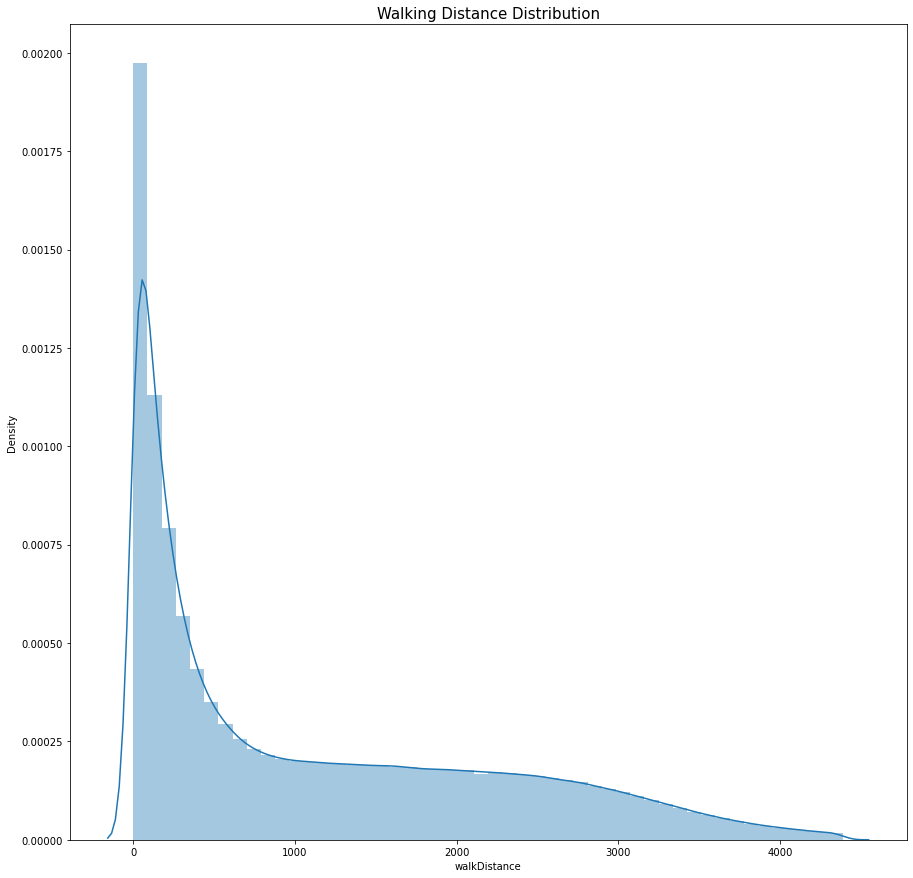

In [49]:
temp = train.copy()
temp = temp[temp['walkDistance'] < temp['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15, 15))
plt.title("Walking Distance Distribution", fontsize=15)
sns.distplot(temp['walkDistance'])
plt.show()

In [50]:
print("{} players ({:.4f}%) walked 0 meters. This means that they die before even takking a step or they are Away From Keyboard (more possible)".format(len(temp[temp['walkDistance'] == 0]), 100*len(temp[temp['walkDistance'] == 0]) / len(train)))

99602 players (2.2398%) walked 0 meters. This means that they die before even takking a step or they are Away From Keyboard (more possible)


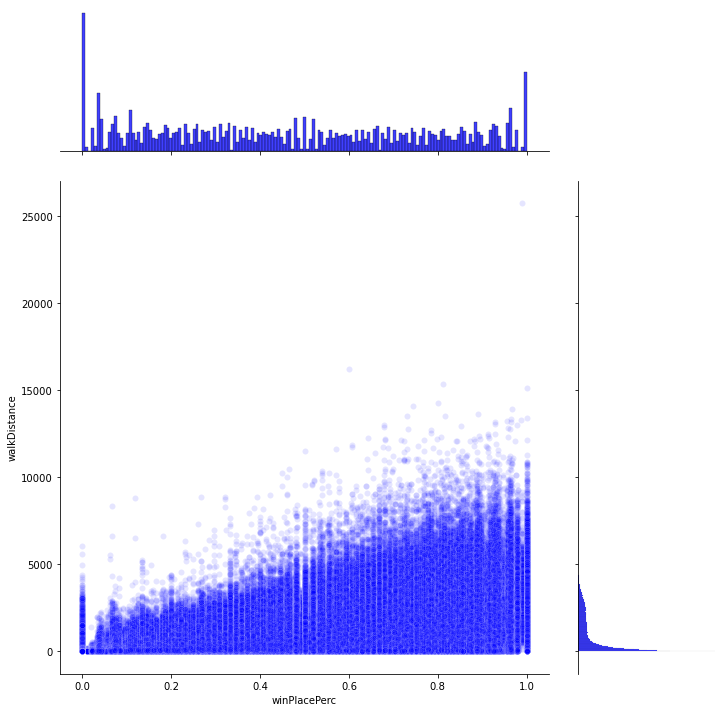

In [51]:
sns.jointplot(x="winPlacePerc", y="walkDistance", data=train, height=10, ratio=3, color="blue", alpha=0.1)
plt.show()

### 2-2-2. boosts 분석

In [52]:
print("The average person uses boosts {:.1f} times, 99% of people have used boosts {} times or less, while maximum time used was {} times".format(np.mean(train['boosts']), train['boosts'].quantile(0.99), np.max(train['boosts'])))

The average person uses boosts 1.1 times, 99% of people have used boosts 7.0 times or less, while maximum time used was 33 times


/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


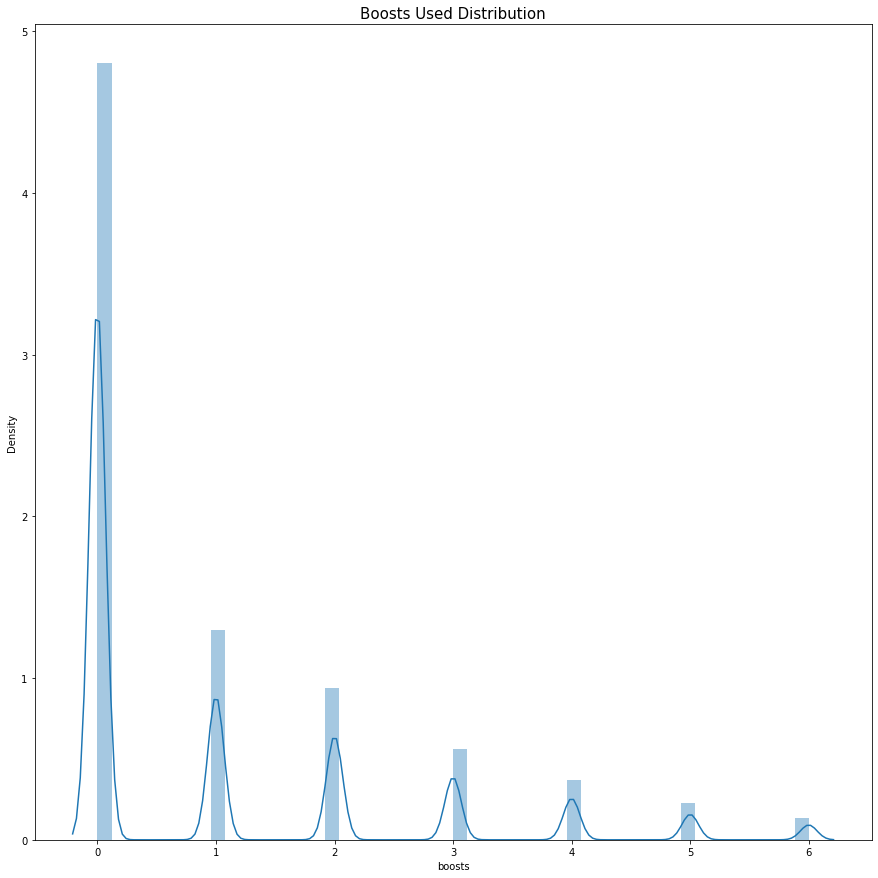

In [53]:
temp = train.copy()
temp = temp[temp['boosts'] < temp['boosts'].quantile(0.99)]
plt.figure(figsize=(15, 15))
plt.title("Boosts Used Distribution", fontsize=15)
sns.distplot(temp['boosts'])
plt.show()

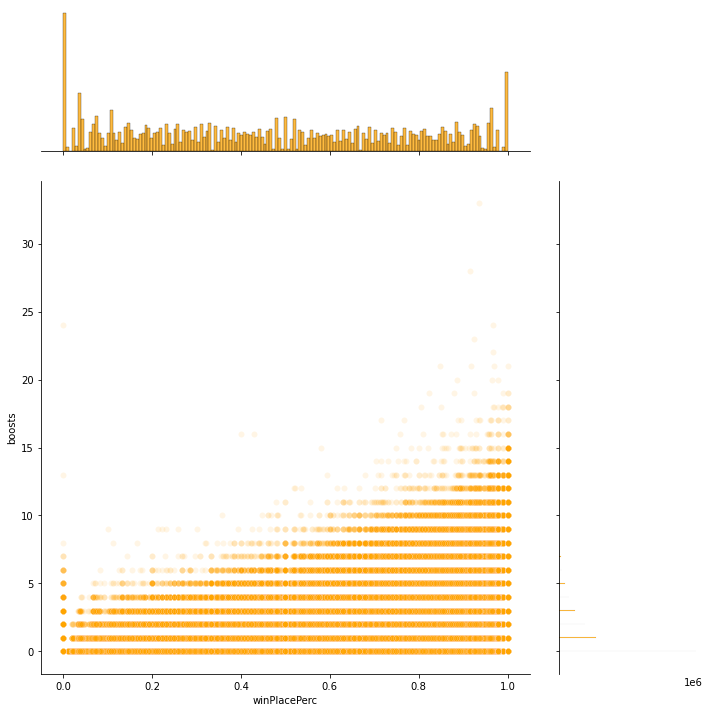

In [54]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="orange", alpha=0.1)
plt.show()

### 2-2-3. weaponsAcquired 분석

In [55]:
print("The average weapons acquired was {:.1f} times, 99% of people have acquired weapons {} times or less, while maximum weapons acquired was {} times".format(np.mean(train['weaponsAcquired']), train['weaponsAcquired'].quantile(0.99), np.max(train['weaponsAcquired'])))

The average weapons acquired was 3.7 times, 99% of people have acquired weapons 10.0 times or less, while maximum weapons acquired was 236 times


/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


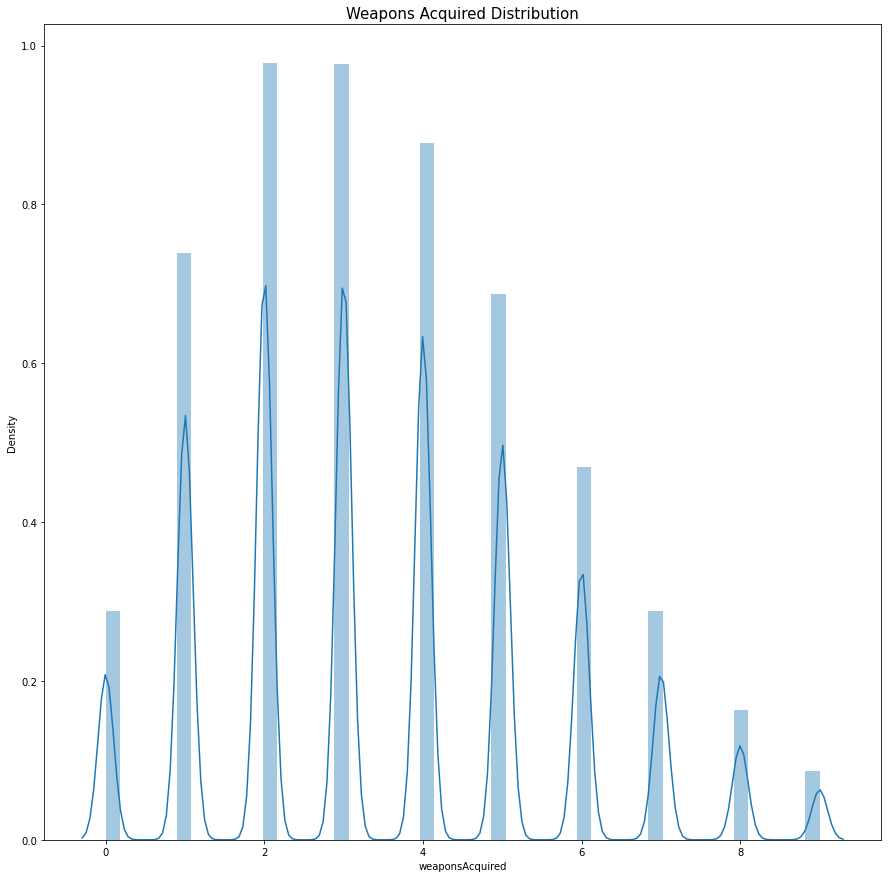

In [56]:
temp = train.copy()
temp = temp[temp['weaponsAcquired'] < temp['weaponsAcquired'].quantile(0.99)]
plt.figure(figsize=(15, 15))
plt.title("Weapons Acquired Distribution", fontsize=15)
sns.distplot(temp['weaponsAcquired'])
plt.show()

In [57]:
train.weaponsAcquired.value_counts()

2      768836
3      768347
4      689622
1      580951
5      540721
        ...  
83          1
102         1
77          1
128         1
92          1
Name: weaponsAcquired, Length: 97, dtype: int64

### 2-2-4. damageDealt 분석

In [58]:
print("The average damageDealt was {:.1f}, 99% of people have dealt {} damage or less, while maximum damage dealt was {}".format(np.sum(train['damageDealt']) / len(train['damageDealt']), train['damageDealt'].quantile(0.99), np.max(train['damageDealt'])))

The average damageDealt was inf, 99% of people have dealt 776.0 damage or less, while maximum damage dealt was 6616.0


/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


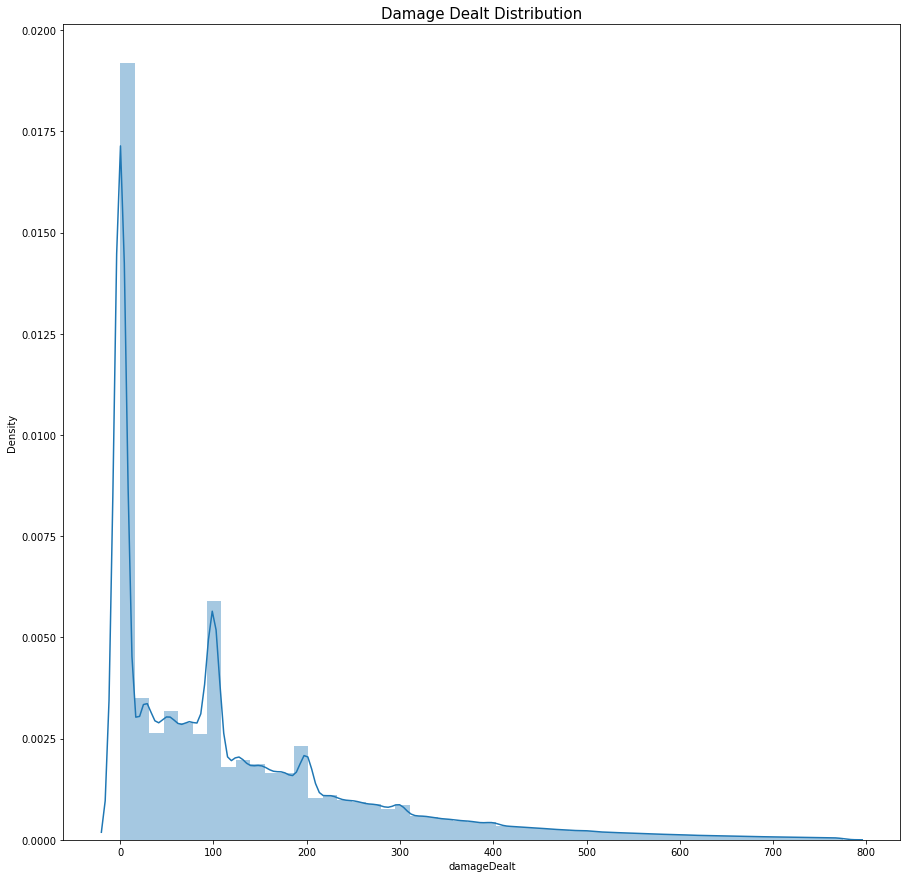

In [59]:
temp = train.copy()
temp = temp[temp['damageDealt'] < temp['damageDealt'].quantile(0.99)]
plt.figure(figsize=(15, 15))
plt.title("Damage Dealt Distribution", fontsize=15)
sns.distplot(temp['damageDealt'])
plt.show()

### 2-2-5. heals 분석

In [60]:
print("The average heals was {:.1f} times, 99% of people have healed {} times or less, while maximum heals was {} times".format(np.mean(train['heals']), train['heals'].quantile(0.99), np.max(train['heals'])))

The average heals was 1.4 times, 99% of people have healed 12.0 times or less, while maximum heals was 80 times


/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


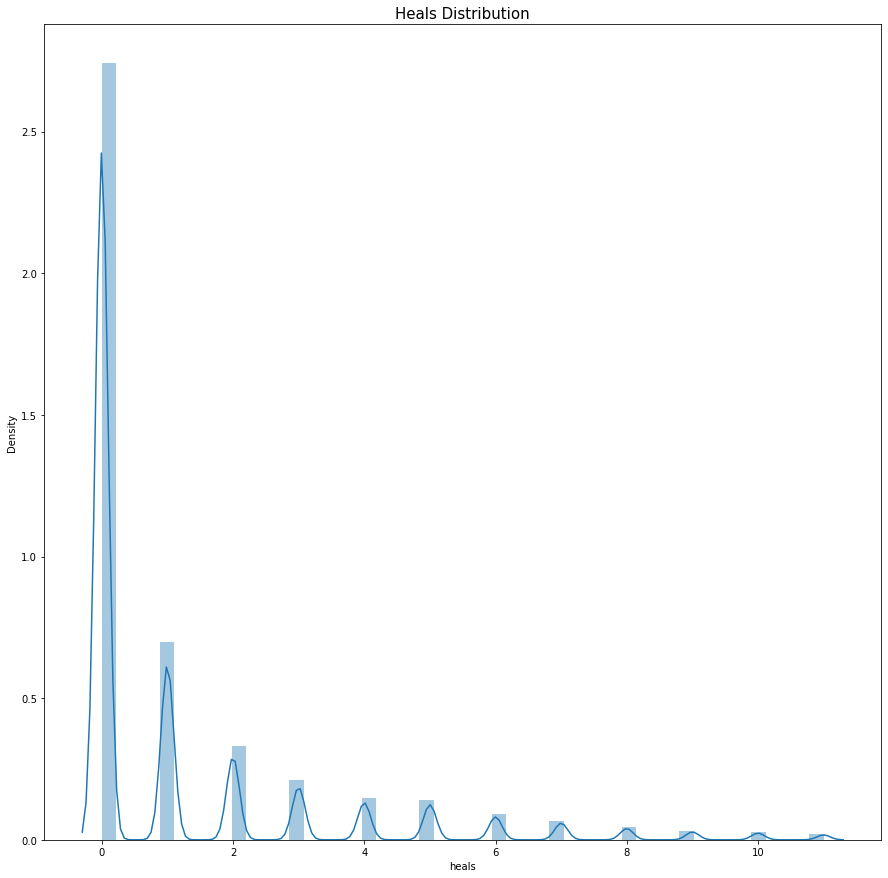

In [61]:
temp = train.copy()
temp = temp[temp['heals'] < temp['heals'].quantile(0.99)]
plt.figure(figsize=(15, 15))
plt.title("Heals Distribution", fontsize=15)
sns.distplot(temp['heals'])
plt.show()

### 2-2-6. kills 분석

/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


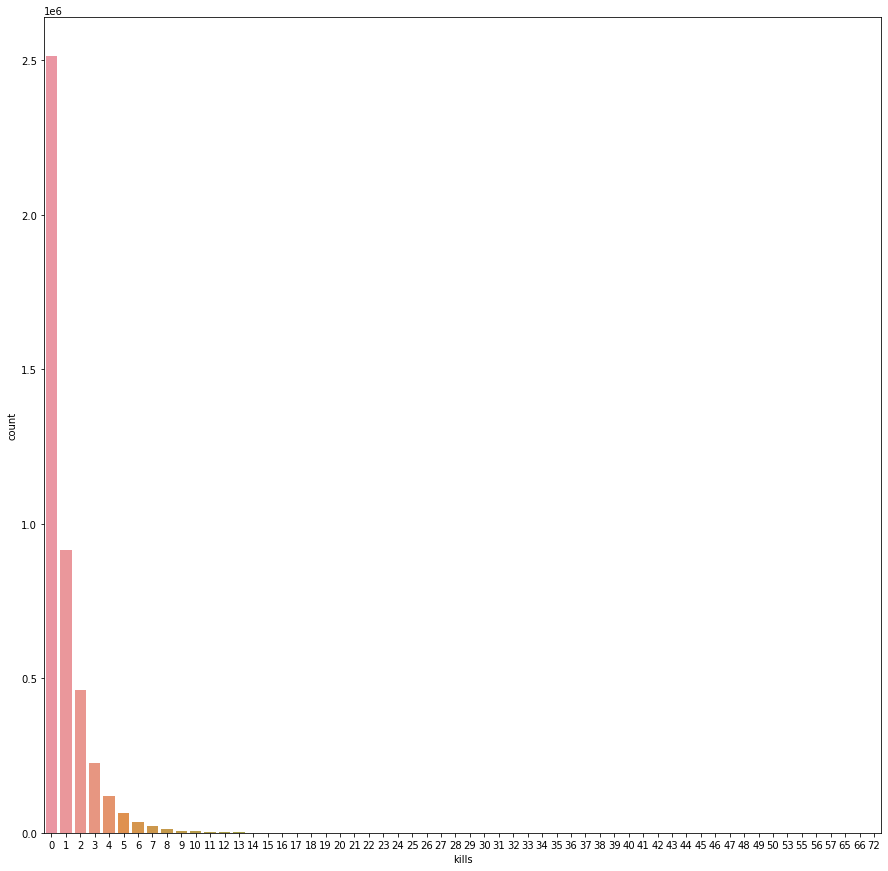

In [64]:
# kills의 value 분포
plt.figure(figsize=(15, 15))
sns.countplot(temp['kills'])
plt.show()

In [66]:
# 72kill 까지 있음.
pd.DataFrame(temp['kills'].value_counts()).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,28,27,29,31,30,33,35,36,41,38,40,34,37,53,42,39,32,43,44,57,66,50,48,56,55,65,47,45,49,72,46
kills,2513604,915526,462791,225867,120215,63845,36284,20806,12174,7288,4338,2666,1653,1064,709,451,301,218,151,100,96,64,64,42,41,24,21,16,15,12,11,10,9,6,6,5,5,4,4,4,4,3,3,3,3,2,2,1,1,1,1,1,1,1,1,1,1,1


In [67]:
# kills의 0.99 quantile이 7이므로, 그 이상은 모두 +8로 분류 가능
temp['kills'].quantile(0.99)

7.0

In [69]:
temp.loc[temp['kills'] > temp['kills'].quantile(0.99)] = '+8'

/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


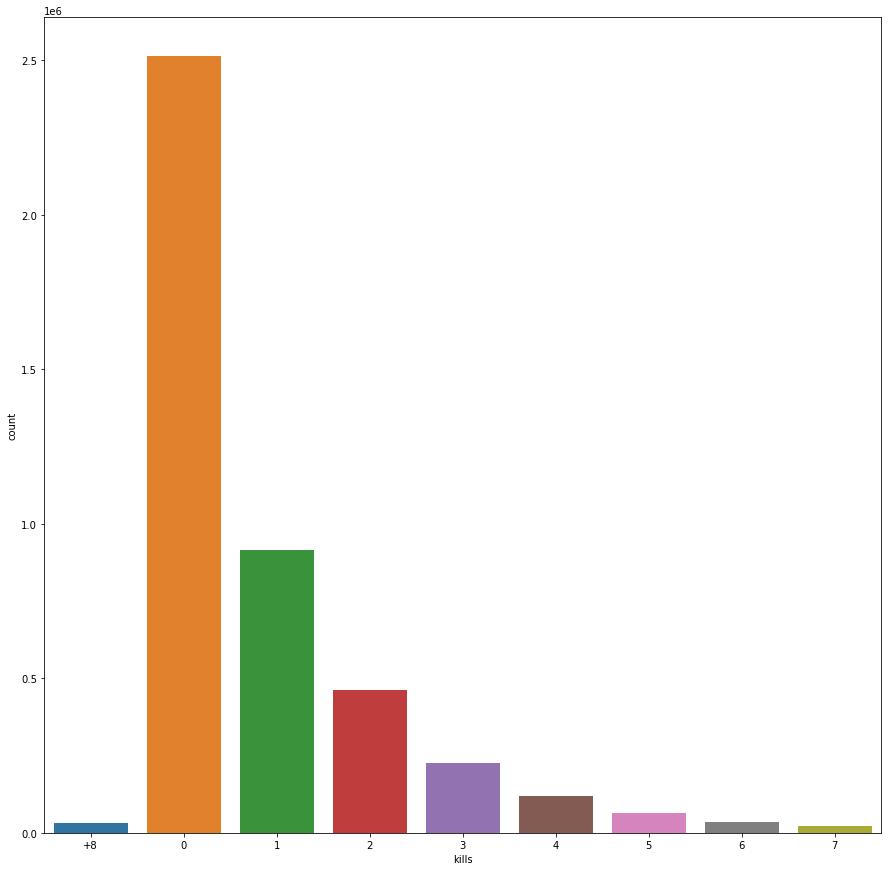

In [70]:
plt.figure(figsize=(15, 15))
sns.countplot(temp['kills'].astype('str').sort_values())
plt.show()

/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


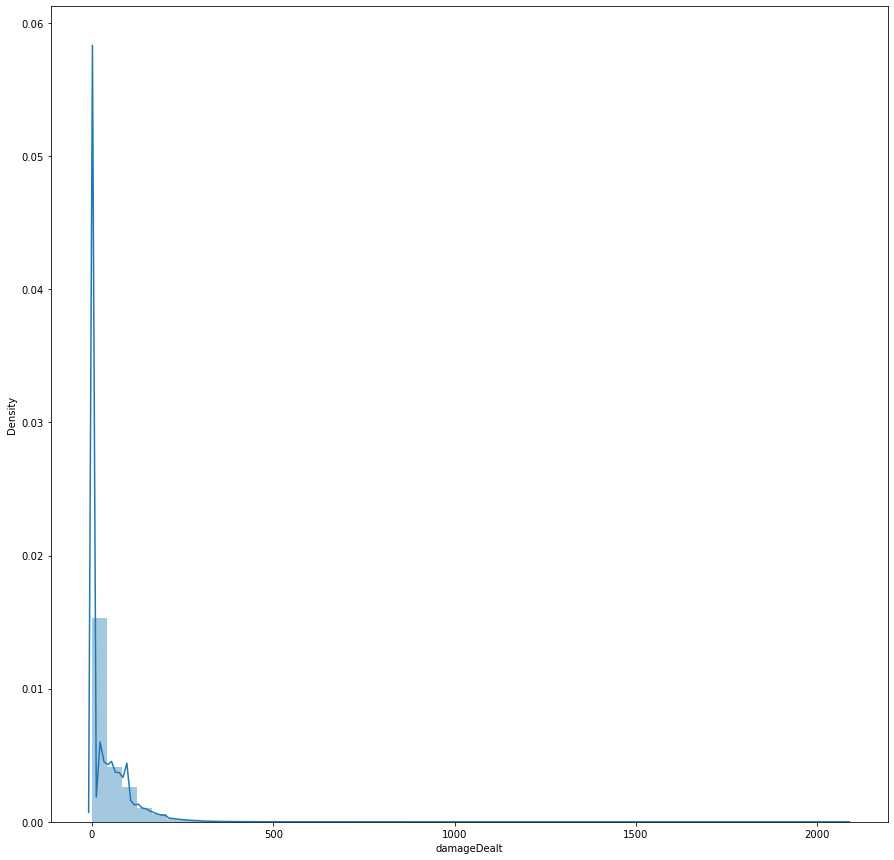

In [71]:
# 0킬인 사람들의 딜량은?
temp = train.copy()
temp = temp[temp['kills'] == 0]
plt.figure(figsize=(15, 15))
sns.distplot(temp['damageDealt'])
plt.show()

In [72]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(temp[temp['winPlacePerc'] == 1]), 100*len(temp[temp['winPlacePerc'] == 1]) / len(train)))
temp1 = train[train['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(temp1[temp1['winPlacePerc'] == 1]), 100*len(temp1[temp1['winPlacePerc'] == 1]) / len(train)))

16666 players (0.3748%) have won without a single kill!
4770 players (0.1073%) have won without dealing damage!


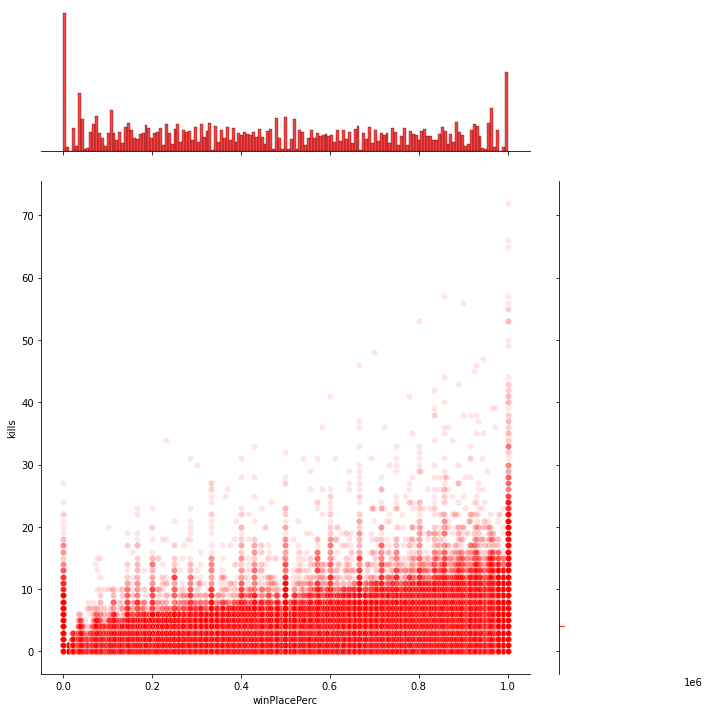

In [73]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color="r", alpha=0.1)
plt.show()

#### Insight
1. 대체로 그래프가 우상향하는 것으로 보아, 킬 수가 많을수록 winPlacePerc가 올라가는 경향이 있음.
2. 다만, 킬수가 30 미만인데 질 확률이 높은 인원들도 있음. (20 미만에 그 밀도가 높음)

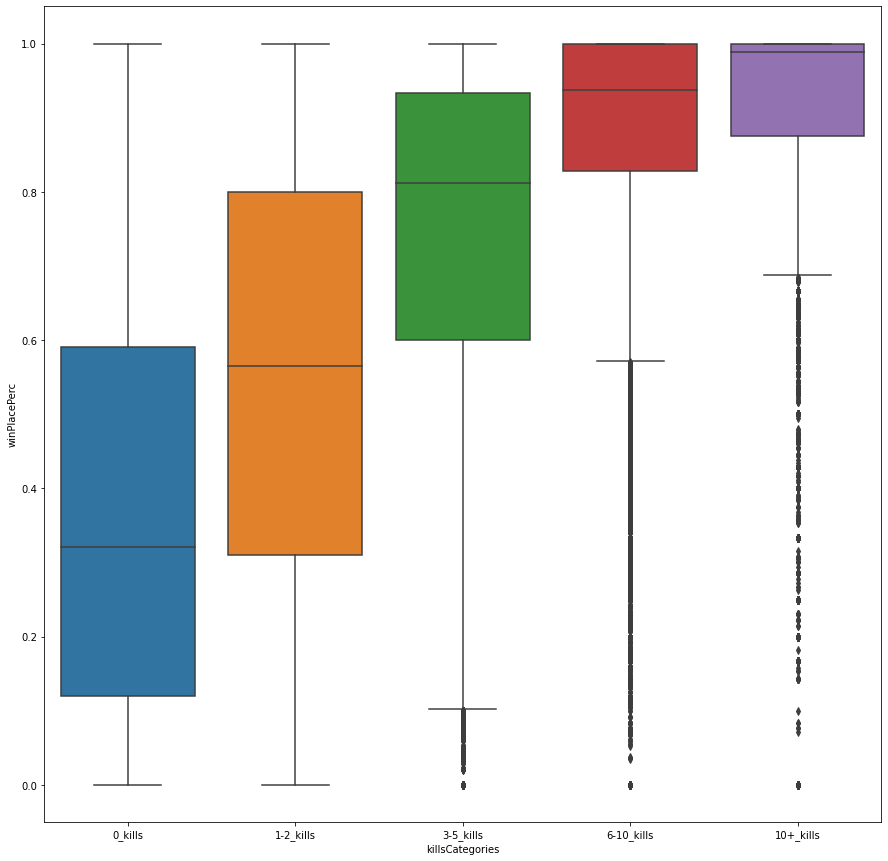

In [74]:
# 0킬, 1-2킬, 3-5킬, 6-10킬, 10킬 이상 분포 확인해보기

temp2 = train.copy()

# pd.cut() = 동일한 길이로 나누기
# pd.cut(ㅔ이터, 구간의 갯수, 레이블명)
temp2['killsCategories'] = pd.cut(temp2['kills'], [-1, 0, 2, 5, 10, 60], 
                                  labels=['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15, 15))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=temp2)
plt.show()

### 2-2-7. longestKill 분석

In [75]:
print("The average longestKill was {:.1f} m, 99% of people sniped {} m, while best sniped {} m".format(np.sum(train['longestKill']) / (train['longestKill'].shape[0] + 0.0001), train['longestKill'].quantile(0.99), np.max(train['longestKill'])))

The average longestKill was inf m, 99% of people sniped 243.75 m, while best sniped 1094.0 m


/home/gyoogler/anaconda3/envs/mldl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


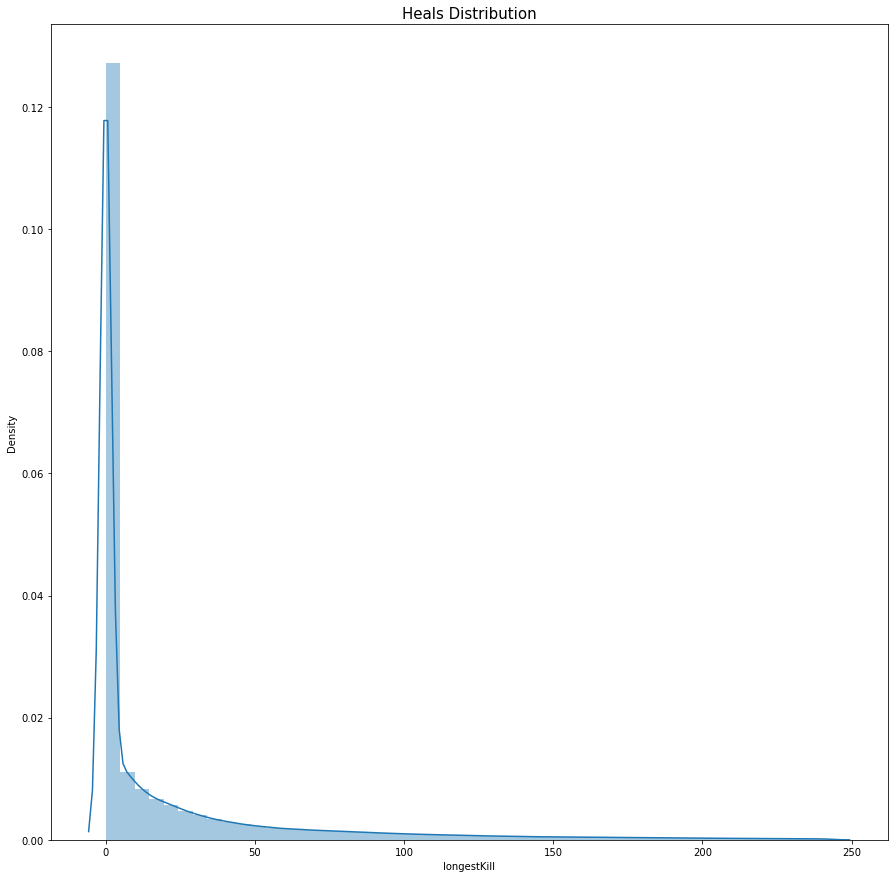

In [76]:
temp = train.copy()
temp = temp[temp['longestKill'] < temp['longestKill'].quantile(0.99)]
plt.figure(figsize=(15, 15))
plt.title("Heals Distribution", fontsize=15)
sns.distplot(temp['longestKill'])
plt.show()

In [ ]:
# visualization code
# def featStat(featureName, constrain,plotType):
#     feat = train[featureName][train[featureName]>0]
#     data = train[[featureName,'winPlacePerc']].copy()
#     q99 = int(data[featureName].quantile(0.99))
#     plt.rcParams['figure.figsize'] = 15,5;   
    
#     if constrain!=None:
#         feat = feat[feat<constrain]
#     if plotType == 'hist':
#         plt.subplot(1,2,1)
#         feat.hist(bins=50);
#         plt.title(featureName);
        
#         n = 20
#         cut_range = np.linspace(0,q99,n)
#         cut_range = np.append(cut_range, data[featureName].max())
#         data[featureName] = pd.cut(data[featureName],
#                                          cut_range,
#                                          labels=["{:.0f}-{:.0f}".format(a_, b_) for a_, b_ in zip(cut_range[:n], cut_range[1:])],
#                                          include_lowest=True
#                                         )
#         ax = plt.subplot(1,2,2)
#         sns.boxplot(x="winPlacePerc", y=featureName, data=data, ax=ax, color="#2196F3")
#         ax.set_xlabel('winPlacePerc', size=14, color="#263238")
#         ax.set_ylabel(featureName, size=14, color="#263238")
#         plt.gca().xaxis.grid(True)
#         plt.tight_layout()
           
#     if plotType == 'count':        
#         plt.subplot(1,2,1)
#         sns.countplot(feat, color="#2196F3");
        
#         plt.subplot(1,2,2)
#         data.loc[data[featureName] > q99, featureName] = q99+1
#         x_order = data.groupby(featureName).mean().reset_index()[featureName]
#         x_order.iloc[-1] = str(q99+1)+"+"
#         data[featureName][data[featureName] == q99+1] = str(q99+1)+"+"
        
#         ax = sns.boxplot(x=featureName, y='winPlacePerc', data=data, color="#2196F3", order = x_order);
#         ax.set_xlabel(featureName, size=14, color="#263238")
#         ax.set_ylabel('WinPlacePerc', size=14, color="#263238")
#     plt.tight_layout()

kills와 damageDealt 사이에는 확실한 상관관계가 있으며, kills가 적을수록 outlier는 더 많다

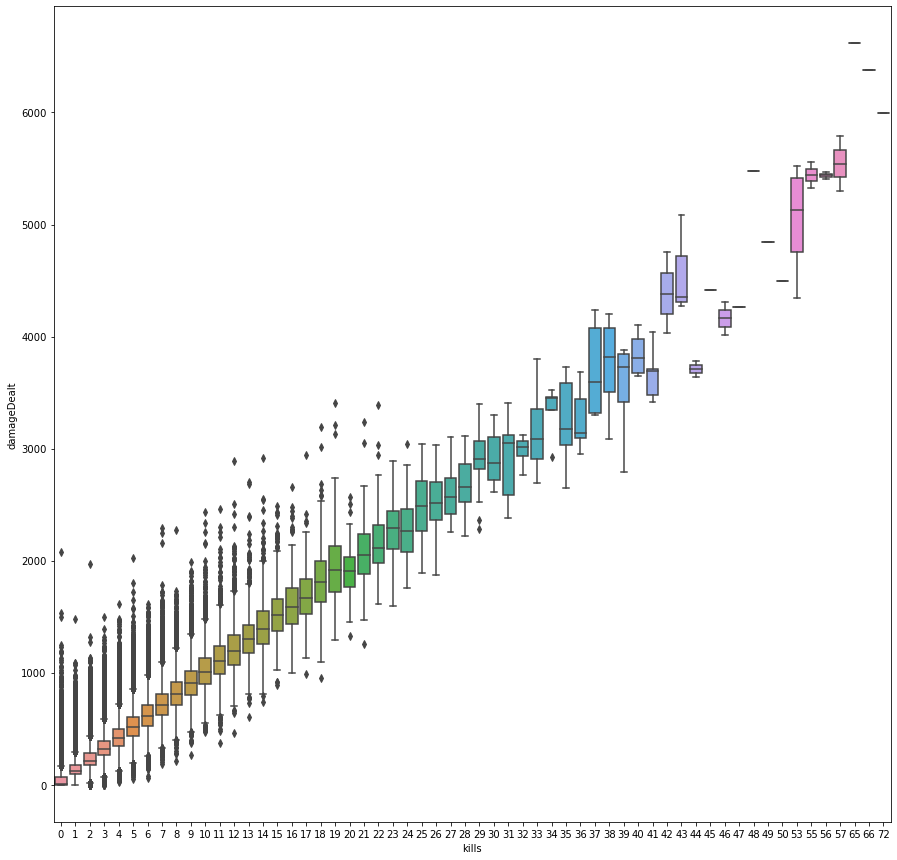

In [79]:
plt.figure(figsize=(15, 15))
sns.boxplot(x='kills', y='damageDealt', data=train)
plt.show()

In [80]:
train[train.kills == 72]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3431247,06308c988bf0c2,4c4ee1e9eb8b5e,6680c7c3d17d48,7,4,5992.00000,0,64,10,1,0,72,7,78.25000,1800,normal-squad,15,15,1500,0,0.00000,0,0.00000,0,0,728.00000,35,0,1.00000


matchId의 참여한 인원수보다 kills가 더 많은 것은, 무엇인가? 봇을 상대로 게임을 했다는 것인가?

In [82]:
# 인원 47, 그렇지만 maxkill 72
train[train.matchId == '6680c7c3d17d48'].shape

(47, 29)

In [88]:
train[train.matchId == '6680c7c3d17d48']['kills'].sum()

687

게임 참여인원은 47명이지만 최대 킬수가 72, 해당 게임의 총 킬수가 687인 것으로 보아 bot전일 것으로 추측함.

In [7]:
temp.shape

(4446965, 29)

# 3. Preprocessing

## 3-1. 이상치 탐색 및 제거

총 인원보다 킬수가 많은 match 제거 (bot전 혹은 death match로 생각할 수도 있지만, 제거)

In [10]:
temp1 = train.copy()
how = {
    'kills' : sum,
    'Id' : np.count_nonzero
}
group_temp = temp1.groupby('matchId').agg(how)
abnormal_game = group_temp[group_temp.loc[:, 'kills'] > group_temp.loc[:, 'Id']].index
abnormal_game = abnormal_game.tolist()

In [11]:
temp1 = temp1.drop(temp1[temp1['matchId'].isin(abnormal_game)].index)

각 match의 group안의 총 플레이어 수

In [12]:
agg = temp1.groupby('groupId').size().to_frame('playerinGame')
temp1 = temp1.merge(agg, how='left', on='groupId')

In [13]:
temp1.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playerinGame
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.00000,0,0.00000,0,0,244.75000,1,1466,0.44434,4
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.00450,0,11.03906,0,0,1434.00000,5,0,0.64014,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.00000,0,0.00000,0,0,161.75000,2,0,0.77539,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.00000,0,0.00000,0,0,202.75000,3,0,0.16675,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.00000,0,0.00000,0,0,49.75000,2,0,0.18750,1


group 인원수가 4명 초과인 인원들 전처리

solo 게임 인원 전처리

In [14]:
temp1.loc[(temp1['matchType'].str.contains('solo')) & (temp1['playerinGame'] != 1), 'playerinGame'] = 1

In [15]:
# (temp[(temp['matchType'].str.contains('solo')) & (temp['playerinGame'] != 1)]['playerinGame'] != 1).sum()
# temp[(temp['matchType'].str.contains('solo')) & (temp['playerinGame'] != 1)]

duo 게임 인원 전처리

In [16]:
temp1.loc[(temp1['matchType'].str.contains('duo')) & (temp1['playerinGame'] > 2), 'playerinGame'] = 2

In [17]:
# (temp[(temp['matchType'].str.contains('duo')) & (temp['playerinGame'] > 2)]['playerinGame'] > 2).sum()
# temp[(temp['matchType'].str.contains('duo')) & (temp['playerinGame'] > 2)]

squad 게임 인원 전처리

In [18]:
temp1.loc[(temp1['matchType'].str.contains('squad')) & (temp1['playerinGame'] > 4), 'playerinGame'] = 4

In [19]:
# (temp[(temp['matchType'].str.contains('squad')) & (temp['playerinGame'] > 4)]['playerinGame'] > 4).sum()
# temp[(temp['matchType'].str.contains('squad')) & (temp['playerinGame'] > 4)]

In [20]:
# test 데이터 가공
test1 = test.copy()
agg = test1.groupby('groupId').size().to_frame('playerinGame')
test1 = test1.merge(agg, how='left', on='groupId')

test1.loc[(test1['matchType'].str.contains('solo')) & (test1['playerinGame'] != 1), 'playerinGame'] = 1
test1.loc[(test1['matchType'].str.contains('duo')) & (test1['playerinGame'] > 2), 'playerinGame'] = 2
test1.loc[(test1['matchType'].str.contains('squad')) & (test1['playerinGame'] > 4), 'playerinGame'] = 4
test1['totalDistance'] = test1['walkDistance'] + test1['swimDistance'] + test1['rideDistance']
# test1.to_csv('test_processed.csv', index=False)
# pd.read_csv('test_processed.csv').head()

In [21]:
# plt.figure(figsize=(15, 15))
# sns.heatmap(temp.corr(), annot=True, fmt='.2f')

In [22]:
temp1.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playerinGame
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.00000,0,0.00000,0,0,244.75000,1,1466,0.44434,4
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.00450,0,11.03906,0,0,1434.00000,5,0,0.64014,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.00000,0,0.00000,0,0,161.75000,2,0,0.77539,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.00000,0,0.00000,0,0,202.75000,3,0,0.16675,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.00000,0,0.00000,0,0,49.75000,2,0,0.18750,1


# 4. Feature Engineering

### 4-1. 움직인 거리 분석

In [23]:
temp2 = temp1.copy()

In [24]:
temp2['totalDistance'] = temp2['walkDistance'] + temp2['swimDistance'] + temp2['rideDistance']

In [25]:
temp2.shape

(4437926, 31)

>총 움직임이 0이지만 킬수가 있고 무기는 없는데 최장 킬거리가 0 이상이면 이상치로 간주, 제거

In [26]:
arr = temp2.loc[(temp2['totalDistance'] == 0) & (temp2['kills'] != 0) & (temp2['longestKill'] > 0) & (temp2['weaponsAcquired'] == 0)]['Id'].values

In [27]:
temp2 = temp2[temp2['Id'].isin(arr) == False]
temp2.shape

(4437907, 31)

### 4-2. headshot & longestKill 상관관계 분석

>가정: headshot 많고 longestkill이 멀수록 실력자일 것이다.

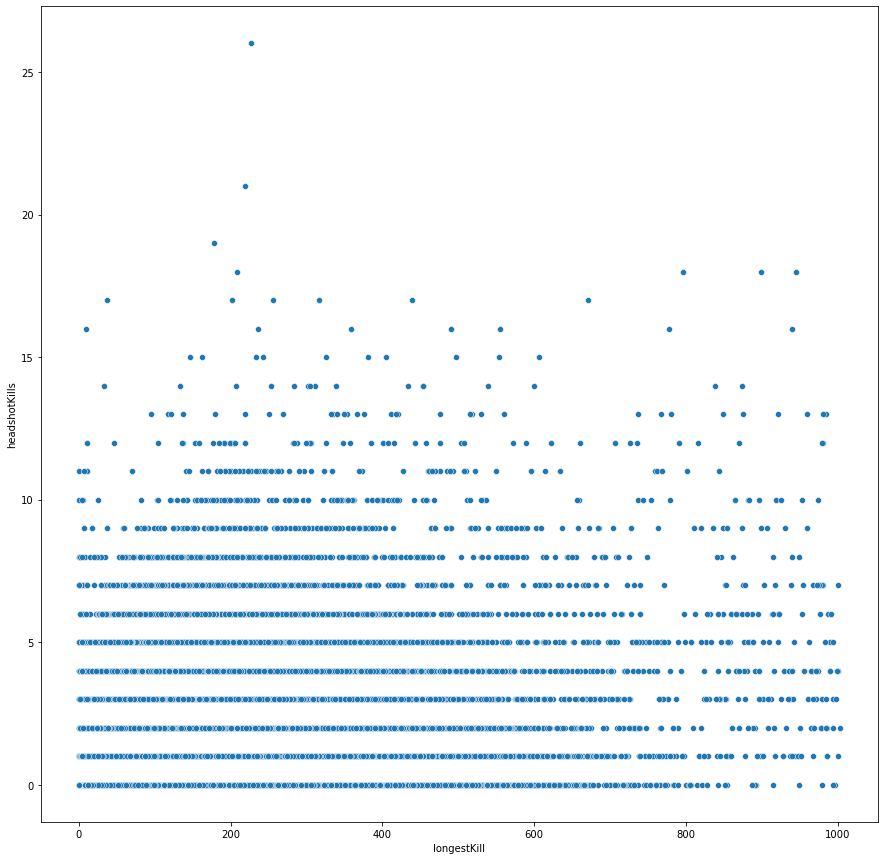

In [48]:
plt.figure(figsize=(15, 15))
sns.scatterplot(data=temp2, x='longestKill', y='headshotKills')
plt.show()

>두 feature의 상관관계를 비교해볼 때, 큰 관계성은 없어 보임.

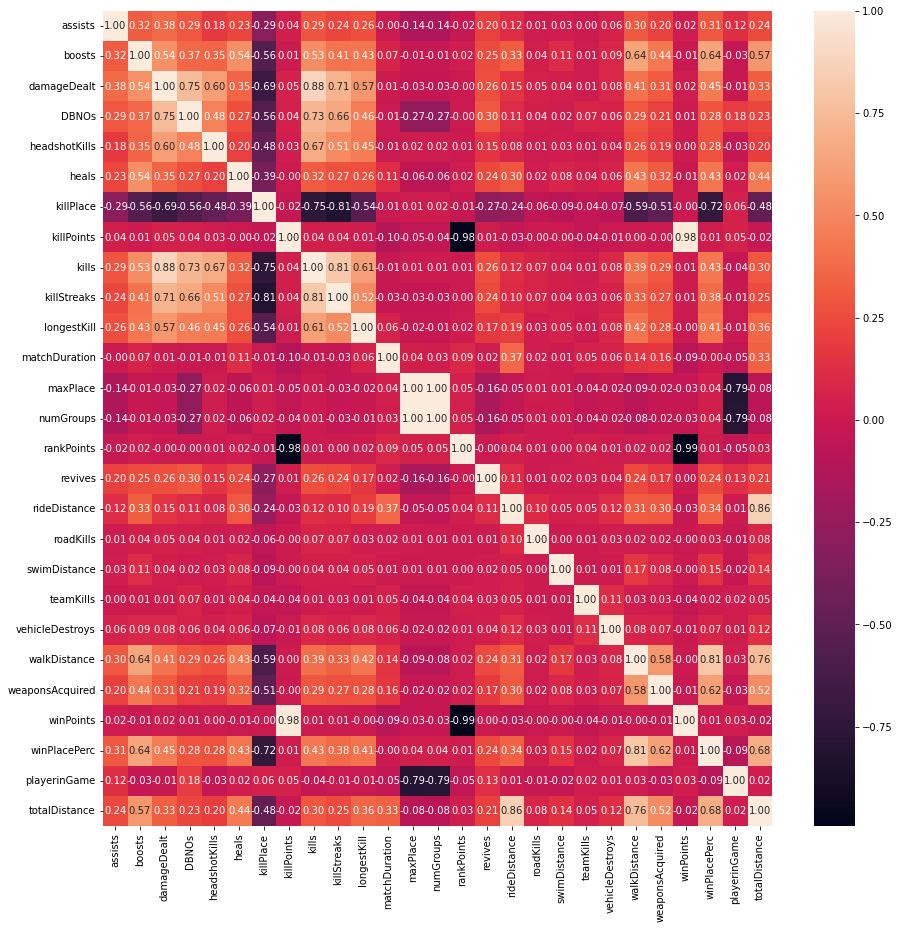

In [59]:
plt.figure(figsize=(15, 15))
sns.heatmap(temp2.corr(), annot=True, fmt='.2f')
plt.show()

>새로 추가한 playerinGame은 target과 큰 상관관계가 없음. 대신 matchType과 비교하여 성능 검증해볼 것. totalDistance와 walkDistance의 차이를 성능검증해볼 것

### 4-3. matchType 3가지로 조정

In [31]:
temp3 = temp2.copy()
temp3['matchType'] = np.where(temp3['matchType'].str.contains('solo'), 'solo', temp3['matchType'])
temp3['matchType'] = np.where(temp3['matchType'].str.contains('duo'), 'duo', temp3['matchType'])
temp3['matchType'] = np.where(temp3['matchType'].str.contains('squad'), 'squad', temp3['matchType'])

# 5. 학습

## 5-1 이상치 제거 및 feature engineering에 대한 학습 및 평가

In [33]:
def encoding(data):
    encoder = LabelEncoder()
    encoder.fit(data['matchType'])
    data['matchType'] = encoder.transform(data['matchType'])

In [34]:
encoding(temp2)
encoding(temp3)
encoding(test1)

In [35]:
temp2 = pd.get_dummies(data=temp2, columns=['matchType'])
temp2 = pd.get_dummies(data=temp2, columns=['playerinGame'])
temp3 = pd.get_dummies(data=temp3, columns=['matchType'])
temp3 = pd.get_dummies(data=temp3, columns=['playerinGame'])
test1 = pd.get_dummies(data=test1, columns=['matchType'])
test1 = pd.get_dummies(data=test1, columns=['playerinGame'])

### 5-1-1. matchId를 사용하여 모델 평가

In [67]:
temp2_1.loc[:,temp2_1.columns.str.startswith('playerinGame')]

,playerinGame_1,playerinGame_2,playerinGame_3,playerinGame_4,playerinGame_5,playerinGame_6,playerinGame_7,playerinGame_8,playerinGame_9,playerinGame_10,playerinGame_11,playerinGame_12,playerinGame_13,playerinGame_14,playerinGame_15,playerinGame_17,playerinGame_18
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437921,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4437922,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4437923,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4437924,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
temp2.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,matchType_0,matchType_1,matchType_2,matchType_3,matchType_4,matchType_5,matchType_6,matchType_7,matchType_8,matchType_9,matchType_10,matchType_11,matchType_12,matchType_13,matchType_14,matchType_15,playerinGame_1,playerinGame_2,playerinGame_3,playerinGame_4,playerinGame_5,playerinGame_6,playerinGame_7,playerinGame_8,playerinGame_9,playerinGame_10,playerinGame_11,playerinGame_12,playerinGame_13,playerinGame_14,playerinGame_15,playerinGame_17,playerinGame_18
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,28,26,-1,0,0.00000,0,0.00000,0,0,244.75000,1,1466,0.44434,244.75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,26,25,1484,0,0.00450,0,11.03906,0,0,1434.00000,5,0,0.64014,1445.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,50,47,1491,0,0.00000,0,0.00000,0,0,161.75000,2,0,0.77539,161.75000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,31,30,1408,0,0.00000,0,0.00000,0,0,202.75000,3,0,0.16675,202.75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,97,95,1560,0,0.00000,0,0.00000,0,0,49.75000,2,0,0.18750,49.75000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# temp2_2 = temp2.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'playerinGame', 'winPlacePerc'])
# test1_2 = test1.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'playerinGame'])
# target2 = temp2['winPlacePerc']

# OHE
temp2_1 = temp2.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'winPlacePerc'])
temp2_1 = temp2_1.drop(temp2_1.loc[:, temp2_1.columns.str.startswith('playerinGame')], axis=1)
test1_1 = test1.drop(columns=['Id', 'groupId', 'matchId', 'killPlace'])
test1_1 = test1_1.drop(test1_1.loc[:, test1_1.columns.str.startswith('playerinGame')], axis=1)
target1 = temp2['winPlacePerc']

In [70]:
X_train, X_val, y_train, y_val = train_test_split(temp2_1, target1, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3550325, 40) (887582, 40) (3550325,) (887582,)


### 5-1-2. playerinGame을 사용하여 모델 평가

In [82]:
# temp2_2 = temp2.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'matchType', 'winPlacePerc'])
# test1_2 = test1.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'matchType'])
# target2 = temp2['winPlacePerc']

# OHE
temp2_2 = temp2.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'winPlacePerc'])
temp2_2 = temp2_2.drop(temp2_2.loc[:, temp2_2.columns.str.startswith('matchType')], axis=1)
test1_2 = test1.drop(columns=['Id', 'groupId', 'matchId', 'killPlace'])
test1_2 = test1_2.drop(test1_2.loc[:, test1_2.columns.str.startswith('matchType')], axis=1)
target2 = temp2['winPlacePerc']

In [83]:
X_train, X_val, y_train, y_val = train_test_split(temp2_2, target2, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3550325, 25) (887582, 25) (3550325,) (887582,)


### 5-1-3. walkDistance를 사용하여 모델 평가

In [90]:
temp2_3 = temp2.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'totalDistance', 'winPlacePerc'])
test1_3 = test1.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'totalDistance'])
target3 = temp2['winPlacePerc']

In [91]:
X_train, X_val, y_train, y_val = train_test_split(temp2_3, target3, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3550325, 25) (887582, 25) (3550325,) (887582,)


### 5-1-4. totalDistance를 사용하여 모델 평가

In [26]:
temp2_4 = temp2.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'walkDistance', 'winPlacePerc'])
test1_4 = test1.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'walkDistance'])
target4 = temp2['winPlacePerc']

In [30]:
X_train, X_val, y_train, y_val = train_test_split(temp2_4, target4, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3550325, 25) (887582, 25) (3550325,) (887582,)


### 5-1-5. matchType solo, duo, squad

In [38]:
temp3_1 = temp3.drop(columns=['Id', 'groupId', 'matchId', 'killPlace', 'winPlacePerc'])
temp3_1 = temp3_1.drop(temp3_1.loc[:, temp3_1.columns.str.startswith('playerinGame')], axis=1)
target5 = temp3['winPlacePerc']

In [40]:
X_train, X_val, y_train, y_val = train_test_split(temp3_1, target5, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3550325, 31) (887582, 31) (3550325,) (887582,)


## 5-2. 통계 기반 이상치 제거

In [45]:
solo = train[train['matchType'].str.contains('solo')]
solo_num = solo['matchId'].value_counts()
print("솔로 참여 인원 수 [평균]     : " , round(solo_num.mean(),1))
print("솔로 참여 인원 수 [중간값]   : " , solo_num.median())
print("솔로 참여 인원 수 [표준편차] : " , round(solo_num.std(),1))
print("솔로 참여 인원 수 [최빈값]   : " , solo_num.mode())

솔로 참여 인원 수 [평균]     :  89.0
솔로 참여 인원 수 [중간값]   :  95.0
솔로 참여 인원 수 [표준편차] :  20.8
솔로 참여 인원 수 [최빈값]   :  0    97
Name: matchId, dtype: int64


In [47]:
solo_num2 = solo['groupId'].value_counts()
print("솔로 그룹 인원 수 [평균]     : " , round(solo_num2.mean(),1))
print("솔로 그룹 인원 수 [중간값]   : " , solo_num2.median())
print("솔로 그룹 인원 수 [표준편차] : " , round(solo_num2.std(),1))
print("솔로 그룹 인원 수 [최빈값]   : " , solo_num2.mode())

솔로 그룹 인원 수 [평균]     :  1.0
솔로 그룹 인원 수 [중간값]   :  1.0
솔로 그룹 인원 수 [표준편차] :  0.4
솔로 그룹 인원 수 [최빈값]   :  0    1
Name: groupId, dtype: int64


In [48]:
print("솔로 그룹 수의 적정 범위 예측 : ",
      round(solo_num.mean()/solo_num2.mean(),1)
      ," ~ ",round(solo_num.median()/solo_num2.median(),1))

솔로 그룹 수의 적정 범위 예측 :  85.7  ~  95.0


In [49]:
duo = train[train['matchType'].str.contains('duo')]
duo_num = duo['matchId'].value_counts()
print("듀오 참여 인원 수 [평균]     : " , round(duo_num.mean(),1))
print("듀오 참여 인원 수 [중간값]   : " , duo_num.median())
print("듀오 참여 인원 수 [표준편차] : " , round(duo_num.std(),1))
print("듀오 참여 인원 수 [최빈값]   : " , duo_num.mode())

듀오 참여 인원 수 [평균]     :  93.0
듀오 참여 인원 수 [중간값]   :  95.0
듀오 참여 인원 수 [표준편차] :  9.4
듀오 참여 인원 수 [최빈값]   :  0    96
Name: matchId, dtype: int64


In [50]:
duo_num2 = duo['groupId'].value_counts()
print("듀오 그룹 인원 수 [평균]     : " , round(duo_num2.mean(),1)) # 듀오가 2.1를 넘을 수가 있나?
print("듀오 그룹 인원 수 [중간값]   : " , duo_num2.median())
print("듀오 그룹 인원 수 [표준편차] : " , round(duo_num2.std(),1))
print("듀오 그룹 인원 수 [최빈값]   : " , duo_num2.mode())

듀오 그룹 인원 수 [평균]     :  2.1
듀오 그룹 인원 수 [중간값]   :  2.0
듀오 그룹 인원 수 [표준편차] :  0.5
듀오 그룹 인원 수 [최빈값]   :  0    2
Name: groupId, dtype: int64


In [51]:
print("듀오 그룹 수의 적정 범위 예측 : ", 
      round(duo_num.mean()/duo_num2.mean(),1),
      " ~ ",round(duo_num.median()/duo_num2.median(),1))

듀오 그룹 수의 적정 범위 예측 :  45.4  ~  47.5


In [52]:
squad = train[train['matchType'].str.contains('squad')]
sqd_num = squad['matchId'].value_counts()
print("스쿼드 참여 인원 수 [평균]     : " , round(sqd_num.mean(),1))
print("스쿼드 참여 인원 수 [중간값]   : " , sqd_num.median())
print("스쿼드 참여 인원 수 [표준편차] : " , round(sqd_num.std(),1))
print("스쿼드 참여 인원 수 [최빈값]   : " , sqd_num.mode())

스쿼드 참여 인원 수 [평균]     :  93.7
스쿼드 참여 인원 수 [중간값]   :  95.0
스쿼드 참여 인원 수 [표준편차] :  8.1
스쿼드 참여 인원 수 [최빈값]   :  0    97
Name: matchId, dtype: int64


In [53]:
sqd_num2 = squad['groupId'].value_counts()
print("스쿼드 그룹 인원 수 [평균]     : " , round(sqd_num2.mean(),1))
print("스쿼드 그룹 인원 수 [중간값]   : " , sqd_num2.median())
print("스쿼드 그룹 인원 수 [표준편차] : " , round(sqd_num2.std(),1))
print("스쿼드 그룹 인원 수 [최빈값]   : " , sqd_num2.mode())

스쿼드 그룹 인원 수 [평균]     :  3.5
스쿼드 그룹 인원 수 [중간값]   :  3.0
스쿼드 그룹 인원 수 [표준편차] :  1.7
스쿼드 그룹 인원 수 [최빈값]   :  0    3
Name: groupId, dtype: int64


In [54]:
print("스쿼드 그룹 수의 적정 범위 예측 : ",
      round(sqd_num.mean()/sqd_num2.mean(),1),
      " ~ ",round(sqd_num.median()/sqd_num2.median(),1))

스쿼드 그룹 수의 적정 범위 예측 :  26.8  ~  31.7


>1. rankPoint는 판수가 많을수록 유리. 감소는 하지 않고 증가만 하기 때문에.
>2. 비정상적인 matchType인원들을 분류해내자.
>3. 90이상은 solo

>##### 그룹의 수 적정범위(1차)
>- 솔로 : 85~100
>- 듀오 : 44~50
>- 스쿼드: 25~32

>##### 각 그룹의 인원 수
>- 솔로 : 1명
>- 듀오 : 1~2명
>- 스쿼드 : 1~4명

In [57]:
matchType_list = temp.matchType.unique().tolist()

# matchType 분류함수
def mT_list(match):
    list = []
    for i in range(len(matchType_list)):
        if match in matchType_list[i]:
            list.append(matchType_list[i])
        else:
            pass
    return list

print(mT_list('duo'))
print(mT_list('squad'))
print(mT_list('solo'))

['duo', 'duo-fpp', 'normal-duo-fpp', 'normal-duo']
['squad-fpp', 'squad', 'normal-squad-fpp', 'normal-squad']
['solo-fpp', 'solo', 'normal-solo-fpp', 'normal-solo']


In [59]:
# 이 코드만 실행시키면 됩니다.
def seek_bug_group_min(temp, match, min_num):

    group_i = temp.loc[temp.matchType == match,:]

    min_i = group_i[group_i['numGroups']<min_num]

    return min_i


def seek_bug_group_max(temp, match, max_num):

    group_i = temp.loc[temp.matchType == match,:]

    max_i = group_i[group_i['numGroups']>max_num]
    
    return max_i

# squad min bug
squad_min_bug = seek_bug_group_min(temp, 'squad', 25)
squad_fpp_min_bug = seek_bug_group_min(temp, 'squad-fpp', 25)
normal_squad_fpp_min_bug = seek_bug_group_min(temp, 'normal-squad-fpp', 25)
normal_squad_min_bug = seek_bug_group_min(temp, 'normal-squad', 25)

# duo min bug
duo_min_bug = seek_bug_group_min(temp, 'duo', 44)
duo_fpp_min_bug = seek_bug_group_min(temp, 'duo-fpp', 44)
normal_duo_fpp_min_bug = seek_bug_group_min(temp, 'normal-duo-fpp', 44)
normal_duo_min_bug = seek_bug_group_min(temp, 'normal-duo', 44)


# solo min bug
solo_fpp_min_bug = seek_bug_group_min(temp, 'solo-fpp', 85)
solo_min_bug = seek_bug_group_min(temp, 'solo', 85)
normal_solo_fpp_min_bug = seek_bug_group_min(temp, 'normal-solo-fpp', 85)
normal_solo_min_bug = seek_bug_group_min(temp, 'normal-solo', 85)

# squad max bug
squad_max_bug = seek_bug_group_max(temp, 'squad', 32)
squad_fpp_max_bug = seek_bug_group_max(temp, 'squad-fpp', 32)
normal_squad_fpp_max_bug = seek_bug_group_max(temp, 'normal-squad-fpp', 32)
normal_squad_max_bug = seek_bug_group_max(temp, 'normal-squad', 32)

# duo max bug
duo_max_bug= seek_bug_group_max(temp, 'duo', 50)
duo_fpp_max_bug = seek_bug_group_max(temp, 'duo-fpp', 50)
normal_duo_fpp_max_bug = seek_bug_group_max(temp, 'normal-duo-fpp', 50)
normal_duo_max_bug = seek_bug_group_max(temp, 'normal-duo', 50)

# solo max bug
solo_max_bug = seek_bug_group_max(temp, 'solo', 100)
solo_fpp_max_bug = seek_bug_group_max(temp, 'solo-fpp', 100)
normal_solo_fpp_max_bug = seek_bug_group_max(temp, 'normal-solo-fpp', 100)
normal_solo_max_bug = seek_bug_group_max(temp, 'normal-solo', 100)

In [61]:
# 이벤트 게임 drop
temp = temp.drop(temp[temp.matchType.str.contains("flare")].index, axis=0)
temp = temp.drop(temp[temp.matchType.str.contains("crash")].index, axis=0)
temp

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.00000,0,0.00000,0,0,244.75000,1,1466,0.44434
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.00450,0,11.03906,0,0,1434.00000,5,0,0.64014
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.00000,0,0.00000,0,0,161.75000,2,0,0.77539
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.00000,0,0.00000,0,0,202.75000,3,0,0.16675
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.00000,0,0.00000,0,0,49.75000,2,0,0.18750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,1029,0,0,0.00000,1873,squad-fpp,29,28,-1,0,1292.00000,0,0.00000,0,0,1019.00000,3,1507,0.17859
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,0,0,0,0.00000,1435,solo,93,93,1501,0,0.00000,0,0.00000,0,0,81.68750,6,0,0.29346
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,0,0,0,0.00000,1321,squad-fpp,28,28,1500,0,0.00000,0,2.18359,0,0,788.50000,4,0,0.48145
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,0,2,1,98.50000,1373,squad-fpp,26,25,1418,2,0.00000,0,0.00000,0,0,2748.00000,8,0,0.79980


# 6. 모델링

In [71]:
# 5-1-1
print("\nFitting LGBM...")
model = LGBMRegressor(importance_type='gain')
model.fit(X_train, y_train)


Fitting LGBM...


LGBMRegressor(importance_type='gain')

In [72]:
print('Prediction')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

Prediction


In [73]:
train_score = mean_absolute_error(y_train, pred_train)
val_score = mean_absolute_error(y_val, pred_val)
print("Train Score : {:.4f}".format(train_score))
print("Validation Score : {:.4f}".format(val_score))

Train Score : 0.0897
Validation Score : 0.0899


In [84]:
# 5-1-2
print("\nFitting LGBM...")
model = LGBMRegressor(importance_type='gain')
model.fit(X_train, y_train)


Fitting LGBM...


LGBMRegressor(importance_type='gain')

In [85]:
print('Prediction')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

Prediction


In [86]:
train_score = mean_absolute_error(y_train, pred_train)
val_score = mean_absolute_error(y_val, pred_val)
print("Train Score : {:.4f}".format(train_score))
print("Validation Score : {:.4f}".format(val_score))

Train Score : 0.0898
Validation Score : 0.0899


In [92]:
# 5-1-3
print("\nFitting LGBM...")
model = LGBMRegressor(importance_type='gain')
model.fit(X_train, y_train)


Fitting LGBM...


LGBMRegressor(importance_type='gain')

In [93]:
print('Prediction')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

Prediction


In [94]:
train_score = mean_absolute_error(y_train, pred_train)
val_score = mean_absolute_error(y_val, pred_val)
print("Train Score : {:.4f}".format(train_score))
print("Validation Score : {:.4f}".format(val_score))

Train Score : 0.0895
Validation Score : 0.0896


In [31]:
# 5-1-4
print("\nFitting LGBM...")
model = LGBMRegressor(importance_type='gain')
model.fit(X_train, y_train)


Fitting LGBM...


LGBMRegressor(importance_type='gain')

In [32]:
print('Prediction')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

Prediction


In [33]:
train_score = mean_absolute_error(y_train, pred_train)
val_score = mean_absolute_error(y_val, pred_val)
print("Train Score : {:.4f}".format(train_score))
print("Validation Score : {:.4f}".format(val_score))

Train Score : 0.0901
Validation Score : 0.0903


In [41]:
# 5-1-5
print("\nFitting LGBM...")
model = LGBMRegressor(importance_type='gain')
model.fit(X_train, y_train)


Fitting LGBM...


LGBMRegressor(importance_type='gain')

In [42]:
print('Prediction')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

Prediction


In [43]:
train_score = mean_absolute_error(y_train, pred_train)
val_score = mean_absolute_error(y_val, pred_val)
print("Train Score : {:.4f}".format(train_score))
print("Validation Score : {:.4f}".format(val_score))

Train Score : 0.0901
Validation Score : 0.0903


# 7. Hyper-parameter Tuning

## 7-1. Hyper-parameter Tuning using Optuna

In [ ]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2'])
    random_states = trial.suggest_int('random_state',0,43) # 여러 값들
    # random_states = trial.suggest_categorical('random_state',[42,1024]) # 리스트 안에만 있는 것 사용 / grid 서치와 유사
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=random_states)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [ ]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="mae", direction="minimize") # regression mae 최소화
rf_study.optimize(opt_func, n_trials=20)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터  lgbm
lgbm_study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % lgbm_study.best_value) # best score 출력
print("Best params: ", lgbm_study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(lgbm_study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(lgbm_study)

In [ ]:
trial = lgbm_study.best_trial
trial_params = trial.params

final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(temp3, target) # finalize model

In [ ]:
# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)
    
prediction = final_lgb_model.predict(test)
submission["y"] = prediction
display(submission)
submission.reset_index(drop=True).to_csv(f"lgbm_submission_{feature_reducing}.csv", index=False)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
rf_study.trials_dataframe()

In [ ]:
print("Best Score: %.5f" % rf_study.best_value) # best score 출력
print("Best params: ", rf_study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(rf_study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(rf_study)

## 7-2. Hyper-parameter Tuning using GridsearchCV

In [ ]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

In [ ]:
gridParams = {
    'num_leaves': [30,50,100], 'max_depth': [-1,7,15], 
    'min_data_in_leaf': [20,50,100],
    'lambda_l1': [0.2],
    'learning_rate': [0.001,0.003, 0.1], 'metric': ['mae'],
    "bagging_fraction" : [0.7]
    }
model = LGBMRegressor()
grid = GridSearchCV(model, gridParams,
                    verbose=1,
                    cv=5)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
print("Best params:", grid.best_params_)
print("\nBest score:", grid.best_score_)
params = grid.best_params_

In [ ]:
new_model = grid.best_estimator_
pred = new_model.predict(temp_test)

In [ ]:
print("Prediction")
pred_test = new_model.predict(temp_test)

# 8. Submission

In [62]:
submission = pd.read_csv('sample_submission_V2.csv')
submission['winPlacePerc'] = pred_test
submission.to_csv('submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission_V2.csv'

In [63]:
submission['winPlacePerc'] = pred_test

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1
...,...,...
1934169,a316c3a13887d5,1
1934170,5312146b27d875,1
1934171,fc8818b5b32ad3,1
1934172,a0f91e35f8458f,1
